<a href="https://colab.research.google.com/github/robinhester/DS-Unit-2-Kaggle-Challenge/blob/master/DS-Unit-2-Kaggle-Challenge/Copy_of_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [9]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
#importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas_profiling
import numpy as np
import plotly.express as px
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [12]:
pandas_profiling.__version__

'2.5.0'

In [13]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [78]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    #Make a copy
    X = X.copy()
    
    #replace zeros in latitude
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    #drop column        
    X = X.drop(columns='quantity_group')
    
    #get top ten subvillage and replace others with other
    top10=X['subvillage'].value_counts()[:10].index
    X.loc[~X['subvillage'].isin(top10),'subvillage']== 'Other'

    #replace zeros in population
    pop_with_zero=['population']
    for col in pop_with_zero:
      X[col]=X[col].replace(0, np.nan)

    #get top regions, replace others with other
    top_region=X['region'].value_counts()[:10].index
    X.loc[~X['region'].isin(top_region),'region']=='Other'

    #replace construction year zeros with nan values
    con_with_zeros=['construction_year']
    for col in con_with_zeros:
      X[col]=X[col].replace(0, np.nan)

    #convert recorded year to datetime and get the year
    strings=X.date_recorded.astype(str)
    datetimes=pd.to_datetime(strings)
    X['date_recorded_year']=pd.DatetimeIndex(datetimes).year

    #get the years between date recorded and construction of the well
    X['years_between']=X['date_recorded_year']-X['construction_year']
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [16]:
train.head()

id  amount_tsh  ... date_recorded_year years_between
43360  72938         0.0  ...               2011           NaN
7263   65358       500.0  ...               2011           3.0
2486     469        25.0  ...               2011           1.0
313     1298         0.0  ...               2011           NaN
52726  27001         0.0  ...               2011           NaN

[5 rows x 42 columns]

In [8]:
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [9]:
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [17]:
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])
num_features = train_features.select_dtypes(include='number').columns.tolist()
card = train_features.select_dtypes(exclude='number').nunique()
cat_features = card[card <= 50].index.tolist()

features = num_features + cat_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'date_recorded_year', 'years_between', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [48]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'),  
    DecisionTreeClassifier(random_state=42,min_samples_leaf=9,splitter='best')
)
# Fit on train
pipeline.fit(x_train, y_train)
# Score on val
print('Training Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))
# Predict on test
y_pred = pipeline.predict(x_test)

Training Accuracy 0.8433080808080808
Validation Accuracy 0.773989898989899


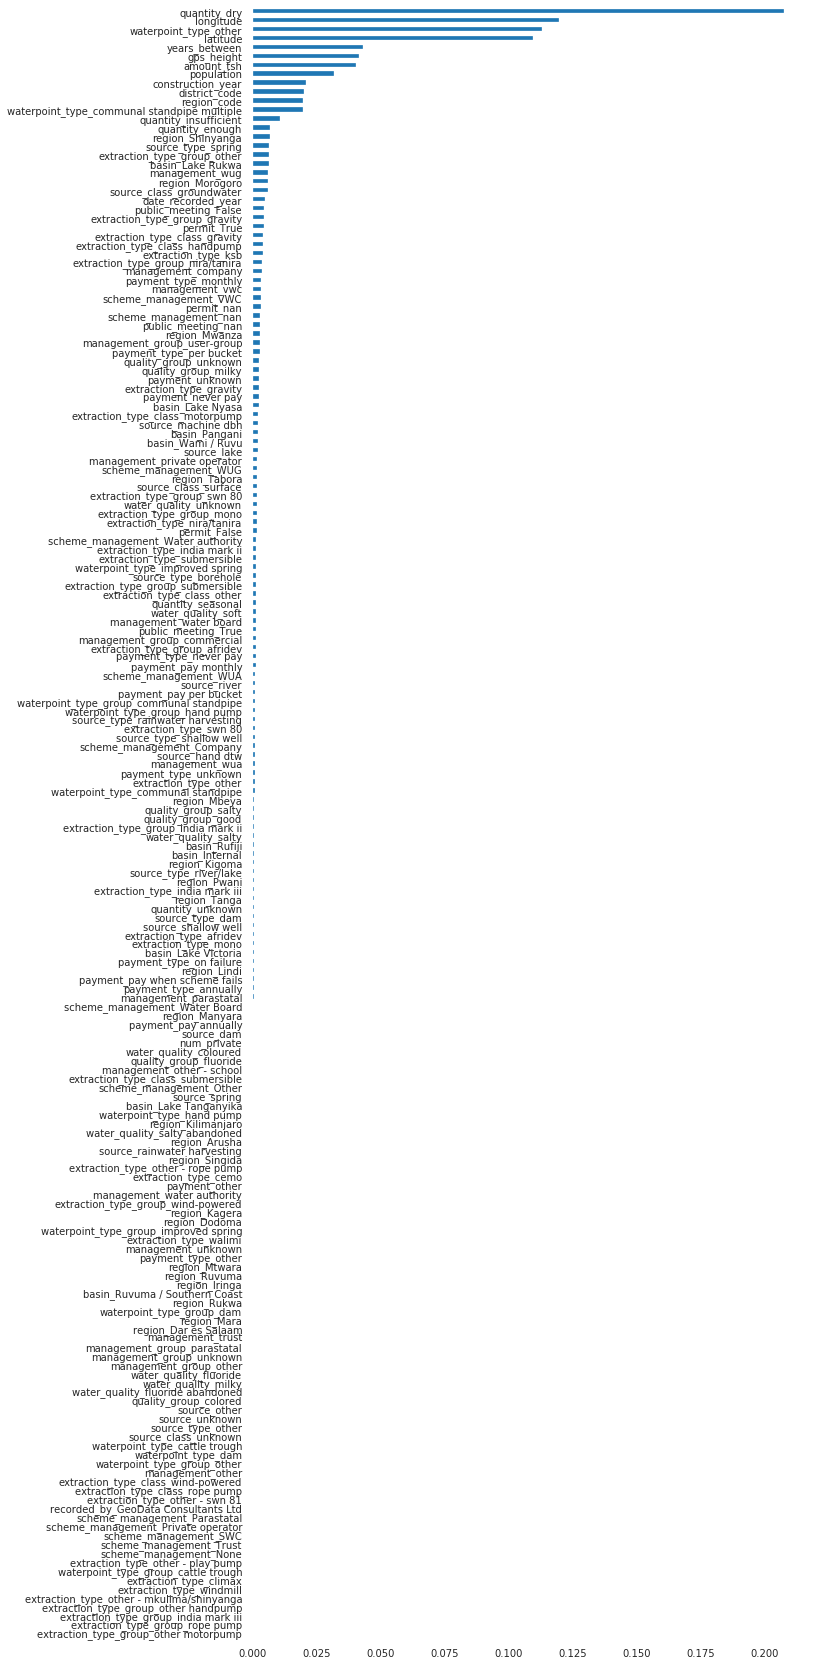

In [49]:
model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series( model.feature_importances_ , encoded_columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

In [0]:
latitude=test.latitude
longitude=test.longitude

In [58]:
print(y_pred)

['functional' 'functional needs repair' 'functional' ... 'functional'
 'functional' 'non functional']


In [59]:
fig = px.scatter_mapbox(y_pred, lat=latitude, lon=longitude, color=y_pred, opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [0]:
submission = test[['id']].copy()
submission['status_group'] = y_pred
# submission['status_group']
submission.to_csv('status_group_ED.csv', index=False)

In [90]:
plots=submission.status_group.value_counts()
plots

functional                 8485
non functional             5235
functional needs repair     638
Name: status_group, dtype: int64

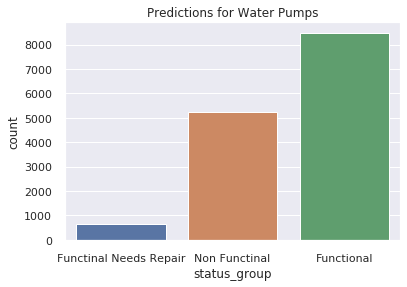

In [110]:
sns.set(style='darkgrid')
g=sns.countplot(x=submission.status_group, data=plots,)
g.set(title='Predictions for Water Pumps')
g.set(xticklabels=(['Functinal Needs Repair','Non Functinal','Functional']))
plt.show()